### Import & Load

In [4]:
# IMPORTS & OTHER SETTINGS
%run 'settings.py'
%matplotlib inline

import logging
# Logging is the verbose for Gensim
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', 
                    level=logging.INFO)

2018-04-04 22:37:52,657 : INFO : 'pattern' package not found; tag filters are not available for English


In [5]:
# File paths
data_path = '../data/'
pickle_path = os.path.join(data_path, 'pickles')
if not os.path.exists(data_path):
    raise Exception('Hold your horses, partner, you need data to continue!')
    
no318_listings = os.path.join(data_path, 'neworleans/listings.csv')
sf318_listings = os.path.join(data_path, 'sanfrancisco/listings.csv')
pd218_listings = os.path.join(data_path, 'portland/listings.csv')
sy118_listings = os.path.join(data_path, 'sydney/listings.csv')
ny318_listings = os.path.join(data_path, 'newyork/listings.csv')

nltk_dwnl = os.path.join(data_path, 'nltk_data')
if not os.path.exists(nltk_dwnl):
    print(f"Downloading {nltk_dwnl}")
    nltk.download('all', download_dir=nltk_dwnl)
    
from nltk.corpus import stopwords

speed_run = True

# This would be for text that needs to be translated. 
# Multithreading might be a solution, but this was too slow to use.
# clean_text_df = os.path.join(data_path,'newyork/cleaned_text_df.pkl')
# if not os.path.exists(clean_text_df):
#     speed_run = False

In [8]:
def get_data(cities):
    dfs = []
    for city in cities:
        dfs.append(pd.read_csv(city, infer_datetime_format=True,
                               parse_dates = ['last_scraped', 'host_since', 
                                              'calendar_last_scraped', 
                                              'first_review', 'last_review'
                                             ]))
    return pd.concat(dfs)

cities = [no318_listings, sf318_listings, pd218_listings, sy118_listings, ny318_listings]

df = get_data(cities).reset_index(drop=True)

print('Speed run:', speed_run)
print(df.shape)
worker = 0
if not speed_run:
    worker, workers = 1, 46
    batch = len(df)/workers
    lower, upper = int(batch * (worker - 1)), int(batch * worker)
    print(lower, upper)
    df = df[lower:upper]
    df.info()

Speed run: True
(48852, 96)


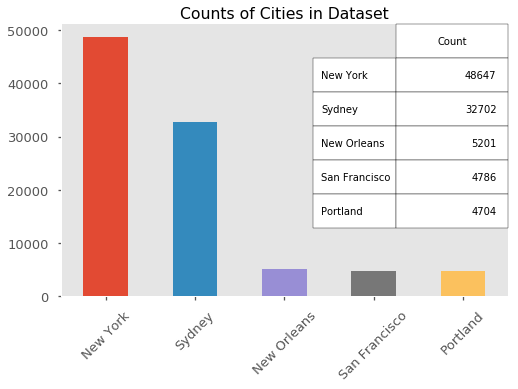

In [4]:
fig, ax = plt.subplots(1,1)
pd.plotting.table(ax, df.market.value_counts()[:5],
                  colLabels=['Count'],
                  bbox=[0.75, 0.25, 0.25, .75])
sns.despine()
df.market.value_counts()[:5].plot(kind='bar', rot=45, 
                                  ax=ax, grid=False, figsize=(8,5))
ax.set_title('Counts of Cities in Dataset');

### Silo Data
Theres a lot of different types of data that I want to silo for focus

In [5]:
# Textual data
text_df = df[['id', 'name', 'summary', 'space', 'description', 
              'neighborhood_overview', 'notes', 'transit', 'access', 
              'amenities'
             ]]

secondary_text_df = df[['id', 'interaction', 'house_rules', 'host_about',
                        'host_neighbourhood', 'host_verifications', 
                        'neighbourhood_cleansed', 'smart_location'
                       ]]

# Host data
host_df = df[['id', 'host_id', 'host_name', 'host_since', 'host_location',
              'host_about', 'host_response_time', 'host_response_rate', 
              'host_is_superhost', 'host_neighbourhood', 'host_listings_count',
              'host_total_listings_count', 'host_verifications', 
              'host_has_profile_pic', 'host_identity_verified',
              'calculated_host_listings_count'
             ]]

# Individual listing Data
listing_df = df[['id', 'scrape_id', 'last_scraped', 'neighbourhood_cleansed', 
                 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode',
                 'zipcode', 'country', 'latitude', 'longitude', 'property_type', 
                 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
                 'bed_type', 'amenities', 'price', 'weekly_price', 
                 'monthly_price', 'security_deposit', 'cleaning_fee',
                 'guests_included', 'extra_people', 'minimum_nights',
                 'maximum_nights', 'requires_license', 'license',
                 'instant_bookable', 'is_business_travel_ready', 
                 'cancellation_policy', 'require_guest_profile_picture', 
                 'require_guest_phone_verification'
                ]]

# Listing review data
reviews_df = df[['id', 'host_id', 'number_of_reviews', 'first_review', 
                 'last_review', 'review_scores_rating', 'review_scores_accuracy',
                 'review_scores_cleanliness', 'review_scores_checkin', 
                 'review_scores_communication', 'review_scores_location',
                 'review_scores_value', 'reviews_per_month'
                ]]

# Calendar data 
calendar_df = df[['id', 'calendar_updated', 'has_availability', 'availability_30',
                  'availability_60', 'availability_90', 'availability_365',
                  'calendar_last_scraped'
                 ]]

[print(x.shape) for x in [text_df, secondary_text_df, host_df, listing_df, reviews_df, calendar_df]]

del df;

(96439, 10)
(96439, 8)
(96439, 16)
(96439, 36)
(96439, 13)
(96439, 8)


### Preprocessing Text

In [6]:
%%time

def clean_text(df, text_field):
    '''
    Clean all the text data within a certain text column of the DataFrame. 
    '''
    df[text_field] = df[text_field].str.replace(r"&[a-z]{2,4};", " ")
    df[text_field] = df[text_field].str.replace(r"[\’\'\`\":]", "")
    df[text_field] = df[text_field].str.replace(r"http\S+", " ")
    df[text_field] = df[text_field].str.replace("\\n", " ")
    df[text_field] = df[text_field].str.replace(r"#f", "")
    df[text_field] = df[text_field].replace(np.NaN, "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9]", " ")
    df[text_field] = df[text_field].str.replace(r" +", " ")
    df[text_field] = df[text_field].str.lower()
    
[clean_text(text_df, column) for column in list(text_df.columns[1:])]
[clean_text(secondary_text_df, column) for column in list(secondary_text_df.columns[1:])]

CPU times: user 42.8 s, sys: 92 ms, total: 42.9 s
Wall time: 42.9 s


In [7]:
# Translating each column of text to english, use for spelling errors and foreign languages!
# Slow processing, some columns did not work properly -- had to skip this step
# Kept code for future use of translations, which can be done as a batch if the length < 15k
print('Skip:', speed_run)

def trans(y, sub, step=3):
    try:
        sleep(.42)
        return translator.translate(list(y[sub:sub + step]))
    except: 
        print(sub)
        sleep(42)
        return trans(y, sub, step)
        
def translatePipe(y):
    translated0 = trans(y, 0)
    translated1 = trans(y, 3)
    translated2 = trans(y, 6)
    translated3 = trans(y, 9)
    translated4 = trans(y, 12)
    
    t = translated0 + translated1 + translated2 + \
        translated3 + translated4 
    return t

if not speed_run:
    from googletrans import Translator
    translator = Translator()
    
    text_df['id'] = text_df['id'].astype('str')
    records = []
    count = 0
    factor = 118
    
    # Access google translator API for scrubbing
    for _, y in text_df.iterrows():
        count += 1
        if count % factor == 0:
            print(count)
            
        record = []
        try:
            translated = translatePipe(y)
        except: 
            print('sleep_m')
            sleep(42)
            translated = translatePipe(y)
        
        for x in translated:
            record.append(x.text)
        records.append(record)
        
    text_df = pd.DataFrame(records, columns=list(text_df.columns))
    text_df['id'] = text_df['id'].astype('uint32')
    
    path='data/newyork/cleaned{}.pkl'.format(worker)
    text_df.to_pickle(pickle_path)
    print(f"My child must sleep now. Goonight #{worker} ~~zZz~ (ー。ー) ~zZz~~")

Skip: True


In [8]:
# # Reading back all the work
# df = pd.DataFrame()
    
# if not speed_run and worker == 1:
#     for i in range(1, workers+1):
#         tmp = pd.read_pickle('data/newyork/cleaned{}.pkl'.format(worker))
#         df = pd.concat([df,tmp], ignore_index=True, verify_integrity=True)
#     text_df1 = df.copy()
#     text_df1.to_pickle(clean_text_df)
    
# else:
#     text_df = pd.read_pickle(clean_text_df)
#     print(text_df.shape)
    
# del df;

### Listings & Host Exploration

Hue
[0] Host Count
[1] Listing Count
-------------------------
           counts       pct
group hue                  
1     0     65600 0.6802227
      1     65600 0.1746032
2     0     13964 0.1447962
      1     27928 0.0743341
3     0      5514 0.0571760
      1     16542 0.0440288
4     0      2628 0.0272504
      1     10512 0.0279791
5     0      1265 0.0131171
      1      6325 0.0168348
...           ...       ...
111   0       111 0.0011510
      1     12321 0.0327940
117   0       117 0.0012132
      1     13689 0.0364351
124   0       124 0.0012858
      1     15376 0.0409253
180   0       180 0.0018665
      1     32400 0.0862370
181   0       181 0.0018768
      1     32761 0.0871978

[102 rows x 2 columns]
-------------------------
5+ %
   counts       pct
0    8733 0.0905547
1  255127 0.6790548


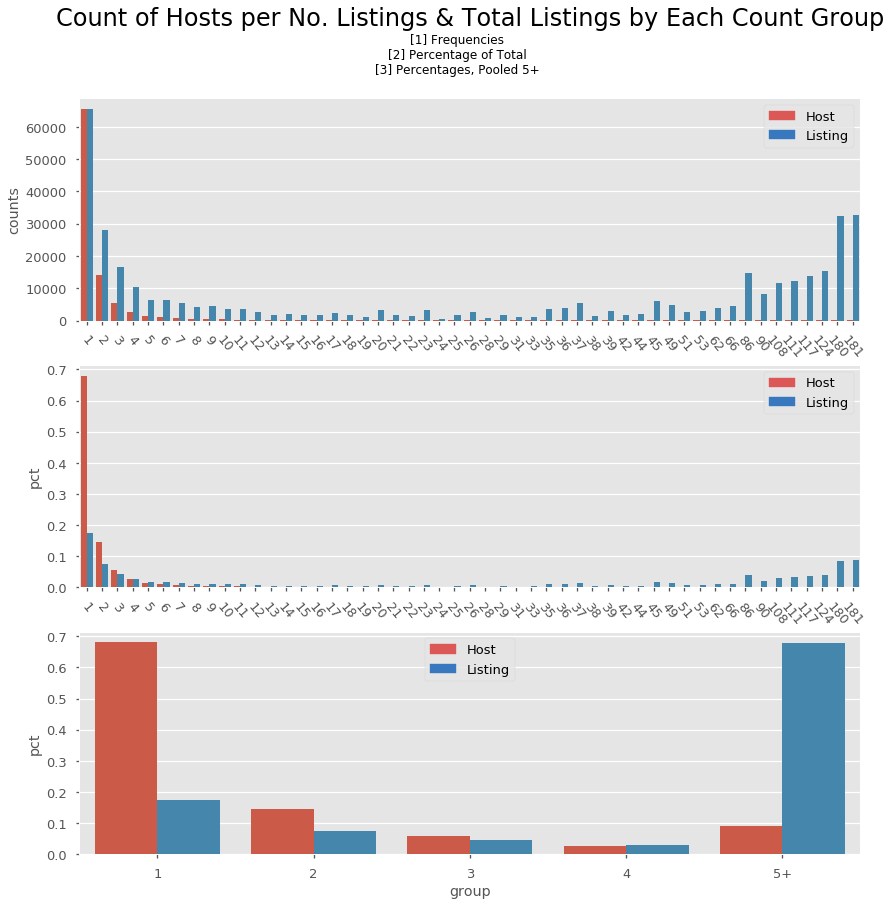

In [9]:
# How many hosts have multiple listings?
tmp = (host_df.calculated_host_listings_count
              .value_counts()
              .to_frame()
              .reset_index()
              .sort_values('index')
              .astype('uint32'))
tmp.columns = ['group', 'counts'] # Host Counts (0)
tmp['hue'] = np.NaN

# Using the counts of calculated host listings, 
# how many actual listings are from that group of hosts?
tmpL = tmp.copy() # L for Listings (1)
tmpL['counts'] = tmp.group * tmp.counts
tmpL = tmpL.fillna(1).astype('uint32')
tmp = pd.concat([tmp[['group', 'counts', 'hue']].fillna(0).astype('uint32'), tmpL])

# Total for calculating percentages per hue
tot = tmp.groupby('hue')['counts'].sum()
tmp['pct'] = list(map(lambda x, y: x/tot[1] if y == 1 else x/tot[0], tmp.counts, tmp.hue))
print('Hue\n[0] Host Count')
print('[1] Listing Count')
print('-'*25)

# Print Data
print(tmp.groupby(['group', 'hue']).sum())
print('-'*25)

# Figure & subplot axes
fig, ax = plt.subplots(3)
fig.set_size_inches((14, 12))

# Frequencies plot
bp = sns.barplot(x='group', y='counts', hue='hue', data=tmp, hue_order=[0, 1], ax=ax[0])
[item.set_rotation(-50) for item in bp.get_xticklabels()]

# Percentages plot
bp = sns.barplot(x='group', y='pct', hue='hue', data=tmp, hue_order=[0, 1], ax=ax[1])
[item.set_rotation(-50) for item in bp.get_xticklabels()]
    
# Pooling 5+
pooled = 5
print('{}+ %'.format(pooled))
print(tmp[(tmp.group >= pooled)].groupby('hue')['counts', 'pct']
                                .sum()
                                .reset_index(drop=True))
tmp = tmp[(tmp.group < pooled)].append(tmp[(tmp.group >= pooled)]
                                       .groupby('hue')['counts', 'pct']
                                       .sum()
                                       .reset_index(drop=True))
tmp.fillna(0, inplace=True)
tmp.iloc[-2:, 1:3] = [['{}+'.format(pooled), 0], ['{}+'.format(pooled), 1]]
sns.barplot(x='group', y='pct', hue='hue', data=tmp, hue_order=[0, 1], ax=ax[2])

# Plot Settings [Legend, Titles, Adjustments]
blu, red = '#3778bf', '#db5856'
patch1 = mpatches.Patch(color=red, label='Host')
patch2 = mpatches.Patch(color=blu, label='Listing')
[ax[i].legend(handles=[patch1, patch2]) for i in range(3)]
plt.subplots_adjust(top=1.)
plt.title('Count of Hosts per No. Listings & Total Listings by Each Count Group', 
           y=3.7, fontdict={'fontsize':24});
plt.suptitle('[1] Frequencies\n[2] Percentage of Total\n[3] Percentages, Pooled {}+'.format(pooled), y=1.075);
plt.sca(ax[2])
plt.xticks(range(5), ['1', '2', '3', '4', '5+'])
del tmpL, tot, fig, ax;

In [10]:
# Host IDs with multiple listings
host_df.host_id.value_counts()[:25]

7409213      181
36410227     180
4962900      135
12243051     126
15739069     117
24831061     111
4335104      108
2450066       90
114353388     86
15651267      66
            ... 
11914644      45
101139031     45
16026854      44
48627526      42
14138978      39
30021442      39
28610148      38
125204161     37
103385102     37
3046924       37
Name: host_id, Length: 25, dtype: int64

### Exploring character lengths of text columns

In [11]:
def length(df, column):
    ''' Lengths of non-null values from a DataFrame column '''
    return np.array([ len(x) for x in df[df[column].notnull()][column] ])

def chopped_len(df, column, base=1, chop=1000):
    ''' Lengths of non-null values from a DataFrame column not including a max level '''
    return np.array([len(x) for x in df[df[column].notnull()][column] if base < len(x) < chop])

def sizing(tmp, lower=min(tmp), upper=max(tmp), buffer=2):
    ''' Bin Settings '''
    bins = int(buffer * (tmp.size**(1/3.)))
    print('Lower Bound:',lower,'\t\t Upper Bound:',upper,'\t Bins:',bins,'\tSize:',tmp.size)
    return bins, lower, upper

def plotter(fig,ax_,tmp,bins,lower,upper,title,xlabel,ylabel=None,l=1,u=1):
    ''' Plots a histogram and density plot'''
    ax = fig.add_subplot(ax_[0], ax_[1], ax_[2])
    sns.distplot(tmp, ax=ax, bins=bins, kde=True, hist=True,
                 norm_hist=False, kde_kws={"lw": 2, "label": "KDE"})
    plt.title(title)
    plt.xlim(lower - l, upper + u)
    if ylabel:
        plt.ylabel(ylabel)
        
    print('Max {}: {}'.format(xlabel, max(tmp)),
          '\t Average {}: {}'.format(xlabel, int(np.mean(tmp))),
          '\t Median {}: {}'.format(xlabel, int(np.median(tmp))))
    
def ylab(tmp):
    return 'Density ({})'.format(tmp.size)

Names (Titles)
Lower Bound: 0 		 Upper Bound: 50 	 Bins: 48 	Size: 94014
Max Length: 49 	 Average Length: 34 	 Median Length: 34
Summaries
Lower Bound: 0 		 Upper Bound: 505 	 Bins: 90 	Size: 94110
Max Length: 991 	 Average Length: 307 	 Median Length: 281

Space (No Spike)
Lower Bound: 0 		 Upper Bound: 1000 	 Bins: 83 	Size: 51622
Max Length: 849 	 Average Length: 325 	 Median Length: 279

Space (Spike)
Lower Bound: 0 		 Upper Bound: 1000 	 Bins: 91 	Size: 67271
Max Length: 998 	 Average Length: 470 	 Median Length: 382

Description (No Spike)
Lower Bound: 0 		 Upper Bound: 1000 	 Bins: 74 	Size: 36556
Max Length: 799 	 Average Length: 391 	 Median Length: 383

Description (Spike)
Lower Bound: 0 		 Upper Bound: 1000 	 Bins: 103 	Size: 96439
Max Length: 998 	 Average Length: 741 	 Median Length: 953

Neighborhood Overview (No Spike)
Lower Bound: 0 		 Upper Bound: 1000 	 Bins: 85 	Size: 55436
Max Length: 949 	 Average Length: 304 	 Median Length: 254

Neighborhood Overview (Spike)
Lowe

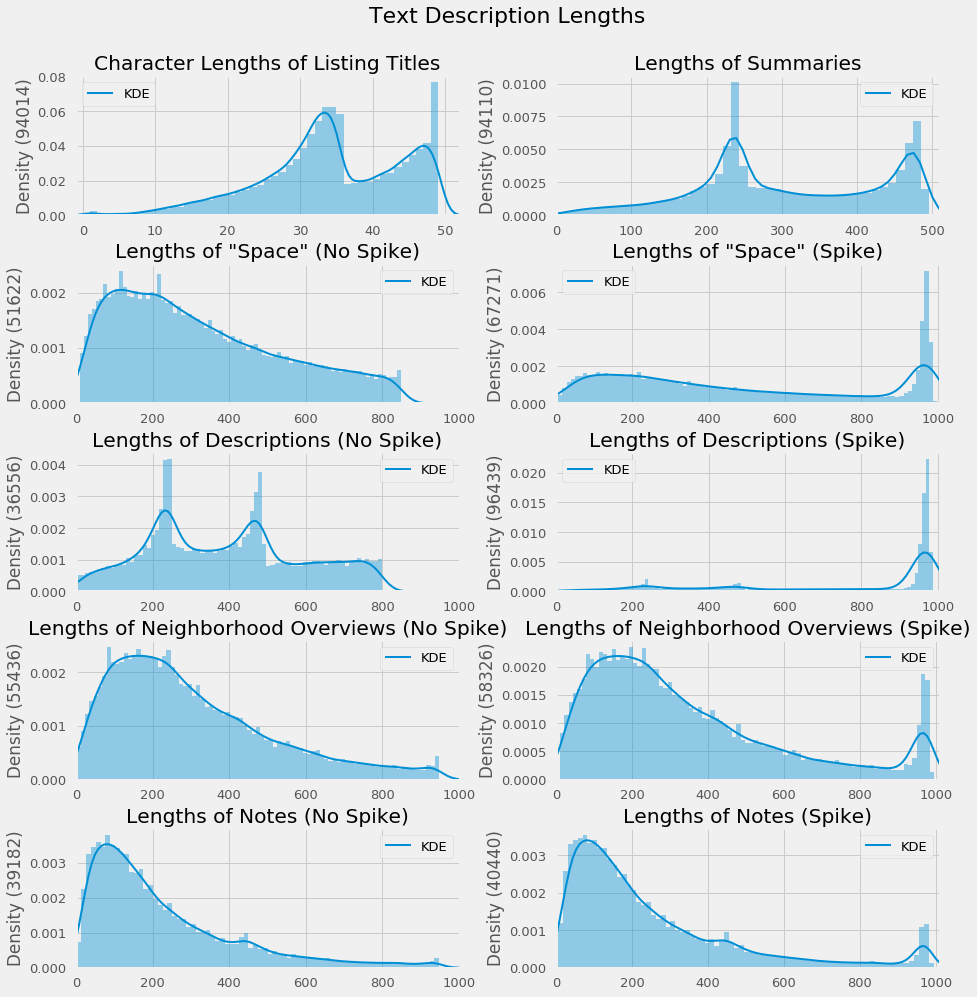

In [12]:
plt.style.use('fivethirtyeight')
# Subplot settings
# Dimensions
d1, d2 = 6, 2
ax_ = []
[ax_.append((d1, d2, i)) for i in range(1, d1*d2)]
fig = plt.figure(figsize=(12,12))
fig.suptitle(t='Text Description Lengths', x=.75, y=1.33, fontsize=22)

# Names
print('Names (Titles)')
column = 'name'
tmp = chopped_len(text_df, column, base=0, chop=50) 
bins, lower, upper = sizing(tmp, lower=0, upper=50, buffer=1.075)
plotter(fig, ax_[0], tmp, bins, lower, upper, title='Character Lengths of Listing Titles',
        xlabel='Length', ylabel=ylab(tmp), l=1, u=2);

# Summaries
print('Summaries')
column = 'summary'
tmp = chopped_len(text_df, column, chop=1000)
bins, lower, upper = sizing(tmp, lower=0, upper=505, buffer=2)
plotter(fig, ax_[1], tmp, bins, lower, upper, title='Lengths of Summaries',
        xlabel='Length', ylabel=ylab(tmp), l=1, u=5);

# Space (Sans spike @ 1000)
print('\nSpace (No Spike)')
column = 'space'
tmp = chopped_len(text_df, column, base=10, chop=850)
bins, lower, upper = sizing(tmp, lower=0, upper=1000, buffer=2.25)
plotter(fig, ax_[2], tmp, bins, lower, upper, title='Lengths of "Space" (No Spike)', 
        xlabel='Length', ylabel=ylab(tmp), l=1, u=2);

# Space (Spike)
print('\nSpace (Spike)')
tmp = chopped_len(text_df, column, base=5, chop=1001)
bins, lower, upper = sizing(tmp, lower=0, upper=1000, buffer=2.25)
plotter(fig, ax_[3], tmp, bins, lower, upper, title='Lengths of "Space" (Spike)', 
         xlabel='Length', ylabel=ylab(tmp), l=1, u=5);

# Description (Sans spike @ 1000)
print('\nDescription (No Spike)')
column='description'
tmp = chopped_len(text_df, column, chop=800)
bins, lower, upper = sizing(tmp, lower=0, upper=1000, buffer=2.25)
plotter(fig, ax_[4], tmp, bins, lower, upper, title='Lengths of Descriptions (No Spike)',
        xlabel='Length', ylabel=ylab(tmp), l=1, u=2);

# Description (Spike)
print('\nDescription (Spike)')
tmp = length(text_df, column)
bins, lower, upper = sizing(tmp, lower=0, upper=1000, buffer=2.25)
plotter(fig, ax_[5], tmp, bins, lower, upper, title='Lengths of Descriptions (Spike)', 
        xlabel='Length', ylabel=ylab(tmp), l=1, u=5);

# Neighborhood Overview (Sans spike @ 1000)
print('\nNeighborhood Overview (No Spike)')
column='neighborhood_overview'
tmp = chopped_len(text_df, column, chop=950)
bins, lower, upper = sizing(tmp, lower=0, upper=1000, buffer=2.25)
plotter(fig, ax_[6], tmp, bins, lower, upper, 
        title='Lengths of Neighborhood Overviews (No Spike)', xlabel='Length',
        ylabel=ylab(tmp), l=1, u=2);

# Neighborhood Overview (Spike)
print('\nNeighborhood Overview (Spike)')
tmp = chopped_len(text_df, column, base=10, chop=1000)
bins, lower, upper = sizing(tmp, lower=0, upper=1000, buffer=2.25)
plotter(fig, ax_[7], tmp, bins, lower, upper,
        title='Lengths of Neighborhood Overviews (Spike)', xlabel='Length', 
        ylabel=ylab(tmp), l=1, u=10);

# Notes (Sans Spike @ 1000)
print('\nNotes (No Spike)')
column='notes'
tmp = chopped_len(text_df, column, chop=950)
bins, lower, upper = sizing(tmp, lower=0, upper=1000, buffer=2.25)
plotter(fig, ax_[8], tmp, bins, lower, upper, title='Lengths of Notes (No Spike)', 
         xlabel='Length', ylabel=ylab(tmp), l=1, u=2);

# Notes (Spike)
print('\nNotes (Spike)')
tmp = chopped_len(text_df, column, base=5, chop=1001)
bins, lower, upper = sizing(tmp, lower=0, upper=1000, buffer=2.25)
plotter(fig, ax_[9], tmp, bins, lower, upper, title='Lengths of Notes (Spike)', 
         xlabel='Length', ylabel=ylab(tmp), l=1, u=10);

# Adjust subplot format
plt.subplots_adjust(left=0.25, right=1.25, bottom=0.0, top=1.25, 
                    hspace=0.35, wspace=.25)

Transit (No Spike)
Lower Bound: 0 		 Upper Bound: 1000 	 Bins: 87 	Size: 59438
Max Length: 899 	 Average Length: 223 	 Median Length: 176
___________________________________________________________________________

Transit (Spike)
Lower Bound: 0 		 Upper Bound: 1000 	 Bins: 88 	Size: 61101
Max Length: 989 	 Average Length: 244 	 Median Length: 182
___________________________________________________________________________

Access
Lower Bound: 0 		 Upper Bound: 1000 	 Bins: 116 	Size: 58708
Max Length: 992 	 Average Length: 170 	 Median Length: 116
___________________________________________________________________________

Interaction
Lower Bound: 0 		 Upper Bound: 1000 	 Bins: 87 	Size: 58708
Max Length: 986 	 Average Length: 166 	 Median Length: 129
___________________________________________________________________________

House Rules (No Spike)
Lower Bound: 0 		 Upper Bound: 1000 	 Bins: 94 	Size: 54552
Max Length: 924 	 Average Length: 203 	 Median Length: 133
___________________

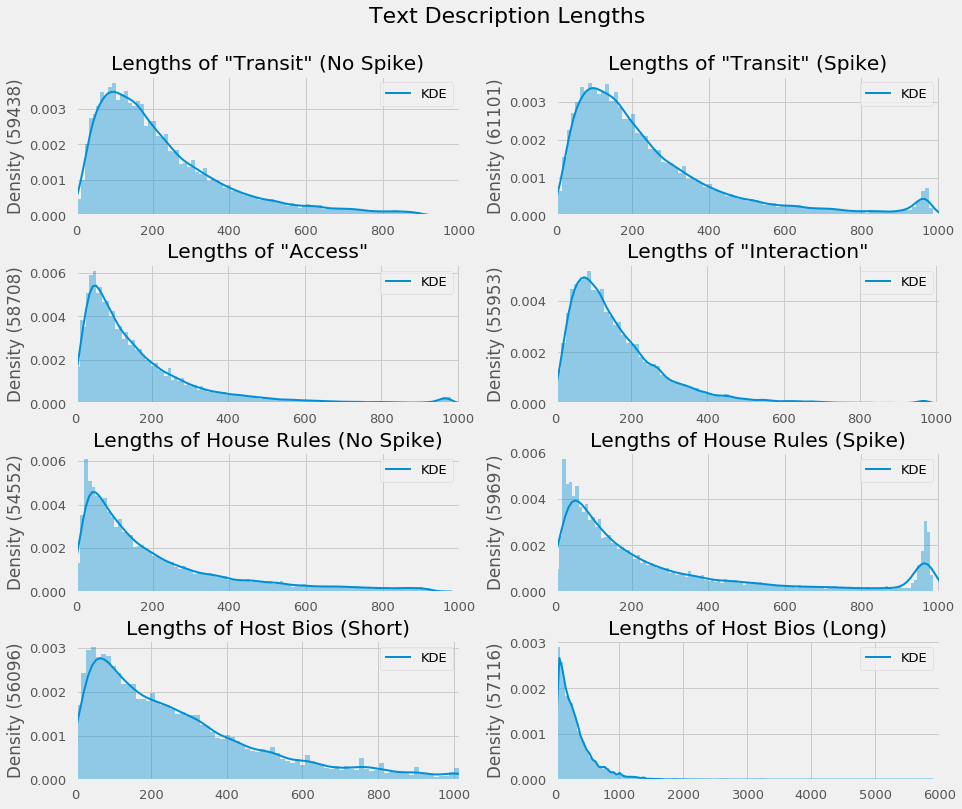

In [13]:
# Subplot settings
# Dimensions
d1, d2 = 6, 2
ax_ = []
[ax_.append((d1, d2, i)) for i in range(1, d1*d2)]
fig = plt.figure(figsize=(12,12))
fig.suptitle(t='Text Description Lengths', x=.75, y=1.33, fontsize=22)

# Transit (Sans Spike @ 1000)
print('Transit (No Spike)')
column='transit'
tmp = chopped_len(text_df, column, chop=900)
bins, lower, upper = sizing(tmp, lower=0, upper=1000, buffer=2.25)
plotter(fig, ax_[0], tmp, bins, lower, upper, title='Lengths of "Transit" (No Spike)', 
        xlabel='Length', ylabel=ylab(tmp), l=1, u=1);

# Transit (Spike)
print("_"*75)
print('\nTransit (Spike)')
tmp = chopped_len(text_df, column, base=5, )
bins, lower, upper = sizing(tmp, lower=0, upper=1000, buffer=2.25)
plotter(fig, ax_[1], tmp, bins, lower, upper, title='Lengths of "Transit" (Spike)', 
        xlabel='Length', ylabel=ylab(tmp), l=1, u=5);

# Access
print("_"*75)
print('\nAccess')
column='access'
tmp = chopped_len(text_df, column, base=2, chop=1001)
bins, lower, upper = sizing(tmp, lower=0, upper=1000, buffer=3)
plotter(fig, ax_[2], tmp, bins, lower, upper, title='Lengths of "Access"', 
        xlabel='Length', ylabel=ylab(tmp), l=-1, u=5);

# Interaction
print("_"*75)
print('\nInteraction')
column='interaction'
tmp = chopped_len(secondary_text_df, column, base=4, chop=1001)
bins, lower, upper = sizing(tmp, lower=0, upper=1000, buffer=2.25)
plotter(fig, ax_[3], tmp, bins, lower, upper, title='Lengths of "Interaction"', 
         xlabel='Length', ylabel=ylab(tmp), l=-1, u=10);

# Transit (Sans Spike @ 1000)
print("_"*75)
print('\nHouse Rules (No Spike)')
column='house_rules'
tmp = chopped_len(text_df, column, chop=925)
bins, lower, upper = sizing(tmp, lower=0, upper=1000, buffer=2.5)
plotter(fig, ax_[4], tmp, bins, lower, upper, title='Lengths of House Rules (No Spike)', 
        xlabel='Length', ylabel=ylab(tmp), l=1, u=1);

# House Rules (Spike)
print("_"*75)
print('\nHouse Rules (Spike)')
tmp = chopped_len(text_df, column, chop=1001)
bins, lower, upper = sizing(tmp, lower=0, upper=1000, buffer=3)
plotter(fig, ax_[5], tmp, bins, lower, upper, title='Lengths of House Rules (Spike)', 
        xlabel='Length', ylabel=ylab(tmp), l=-1, u=5);

# Host Bios
print("_"*75)
print('\nHost About')
column='host_about'
tmp = chopped_len(text_df, column, chop=1250)
bins, lower, upper = sizing(tmp, lower=0, upper=1000, buffer=2.5)
plotter(fig, ax_[6], tmp, bins, lower, upper, title='Lengths of Host Bios (Short)', 
        xlabel='Length', ylabel=ylab(tmp), l=-1, u=15);

# House Rules (Spike)
print("_"*75)
print('\nHost About (Spike)')
tmp = chopped_len(text_df, column, base=1, chop=6000)
bins, lower, upper = sizing(tmp, lower=0, upper=6000, buffer=4)
plotter(fig, ax_[7], tmp, bins, lower, upper, title='Lengths of Host Bios (Long)', 
        xlabel='Length', ylabel=ylab(tmp), l=-1, u=5);

plt.subplots_adjust(left=0.25, right=1.25, bottom=0.0, top=1.25, 
                    hspace=0.35, wspace=.25)
del tmp

### NLP Setup

In [12]:
# "stopEng" is our list of stopwords for use in the vectorizer objects
stopEng = [x.replace("\'", "") for x in stopwords.words('english')]
stopEng.extend(['', 'also','really','ive','even','lot','could','many','im'])

In [13]:
text_bin =  text_df.name + ' ' + text_df.summary + ' ' + text_df.space + ' ' + \
            text_df.description + ' ' + text_df.neighborhood_overview + ' ' + \
            text_df.notes + ' ' + text_df.transit + ' ' + text_df.access + ' ' + \
            text_df.amenities


secondary_text_bin = secondary_text_df.interaction + ' ' + \
                     secondary_text_df.house_rules + ' ' + \
                     secondary_text_df.host_about + ' ' + \
                     secondary_text_df.host_neighbourhood + ' ' + \
                     secondary_text_df.host_verifications + ' ' + \
                     secondary_text_df.neighbourhood_cleansed + ' ' + \
                     secondary_text_df.smart_location

In [14]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Count vectorizer for LSA
cv = CountVectorizer(token_pattern='\\w{2,}', max_df=.35, min_df=.0001, 
                      stop_words=stopEng, ngram_range=(1,2), dtype='uint16')

# Term Frequency - Inverse Document Frequency vectorizer for LSA
tfidf = TfidfVectorizer(token_pattern='\\w{2,}', max_df=.5, min_df=.0001, 
                        stop_words=stopEng, ngram_range=(1,2),
                        sublinear_tf=True, smooth_idf=False, dtype='float32')

In [15]:
%%time

# Count & tf-idf vectorizer fits the tokenizer and transforms data into new matrix
cv_vecs = cv.fit_transform(secondary_text_bin)
tf_vecs = tfidf.fit_transform(text_bin)

cv_vecs_path = os.path.join(pickle_path, 'cv_vecs.pkl')
tf_vecs_path = os.path.join(pickle_path, 'tf_vecs.pkl')
pickle.dump(cv_vecs, open(cv_vecs_path, 'wb'))
pickle.dump(tf_vecs, open(tf_vecs_path, 'wb'))

# Checking the shape and size of the vectorized (transformed) matrix
print("Sparse Shape (cv):\t", cv_vecs.shape) 
print("Sparse Shape (tfidf):\t", tf_vecs.shape)

Sparse Shape (cv):	 (96439, 71804)
Sparse Shape (tfidf): (96439, 182401)
CPU times: user 1min 24s, sys: 2.7 s, total: 1min 27s
Wall time: 1min 27s


In [16]:
# FOR EXPLORING A SUBSET
# tfidf_df = pd.DataFrame(tf_vecs.todense(), columns=[tfidf.get_feature_names()]).astype('float32')
# cv_df = pd.DataFrame(cv_vecs.todense(), columns=[cv.get_feature_names()]).astype('uint8')
# cv_description = cv_df.describe().T
# tfidf_description = tfidf_df.describe().T
# print(cv_df.info())
# print(tfidf_df.info())
# cv_df

In [17]:
# tfidf_df.sum().sort_values(ascending=False)

In [18]:
# cv_description.sort_values(by='max', ascending=False)
#tfidf_description.sort_values(by='mean', ascending=False)

In [19]:
%%time

# Convert sparse matrix of term-doc counts to a gensim corpus
cv_corpus = matutils.Sparse2Corpus(cv_vecs.T)
tfidf_corpus = matutils.Sparse2Corpus(tf_vecs.T)

cv_corpus_path = os.path.join(pickle_path, 'cv_corpus.pkl')
tf_corpus_path = os.path.join(pickle_path, 'tfidf_corpus.pkl')
pickle.dump(cv_corpus, open(cv_vorpus_path, 'wb'))
pickle.dump(tfidf_corpus, open(tf_corpus_path, 'wb'))

# Maps index to term
id2word = dict((v, k) for k, v in cv.vocabulary_.items())
id2word_tf = dict((v, k) for k, v in tfidf.vocabulary_.items())

# This is for Python 3 (?)
id2word = corpora.Dictionary.from_corpus(cv_corpus, id2word=id2word)
id2word_tf = corpora.Dictionary.from_corpus(tfidf_corpus, id2word=id2word_tf)

id2word_path = os.path.join(pickle_path, 'id2word.pkl')
id2word_tf_path = os.path.join(pickle_path, 'id2word_tf.pkl')
pickle.dump(id2word, open(id2word_path, 'wb'))
pickle.dump(id2word_tf, open(id2word_tf_path, 'wb'))

2018-04-02 16:38:26,410 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-04-02 16:38:27,493 : INFO : adding document #10000 to Dictionary(0 unique tokens: [])
2018-04-02 16:38:28,481 : INFO : adding document #20000 to Dictionary(0 unique tokens: [])
2018-04-02 16:38:29,160 : INFO : adding document #30000 to Dictionary(0 unique tokens: [])
2018-04-02 16:38:29,800 : INFO : adding document #40000 to Dictionary(0 unique tokens: [])
2018-04-02 16:38:30,586 : INFO : adding document #50000 to Dictionary(0 unique tokens: [])
2018-04-02 16:38:31,425 : INFO : adding document #60000 to Dictionary(0 unique tokens: [])
2018-04-02 16:38:32,124 : INFO : adding document #70000 to Dictionary(0 unique tokens: [])
2018-04-02 16:38:32,778 : INFO : adding document #80000 to Dictionary(0 unique tokens: [])
2018-04-02 16:38:33,385 : INFO : adding document #90000 to Dictionary(0 unique tokens: [])
2018-04-02 16:38:34,070 : INFO : built Dictionary(71804 unique tokens: ['orleans', 'work', 'in

CPU times: user 31.7 s, sys: 628 ms, total: 32.3 s
Wall time: 32.3 s


Ready for the Recommender notebook!